In [110]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torchvision
import torch
import torch.nn as nn

In [4]:
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

I0000 00:00:1732168167.699250 1402592 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1732168167.710174 1404187 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.90.07), renderer: NVIDIA GeForce RTX 4090/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1732168167.765467 1404189 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732168167.796228 1404204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [21]:
root = "finger_force_db/original_img"
files = os.listdir(root)

In [23]:
for file in tqdm(files):
    path = os.path.join(root, file)

    image = mp.Image.create_from_file(path)
    detection_result = detector.detect(image)

  0%|          | 0/11988 [00:00<?, ?it/s]W0000 00:00:1732171178.905393 1404202 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
/home/brianchen/.local/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
  6%|▌         | 744/11988 [00:24<06:04, 30.87it/s]


KeyboardInterrupt: 

In [76]:
path = "finger_force_db/original_img/21.jpg"

In [133]:
image = mp.Image.create_from_file(path)
detection_result = detector.detect(image)

/home/brianchen/.local/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [83]:
finger_points = [4, 8, 12, 16, 20]

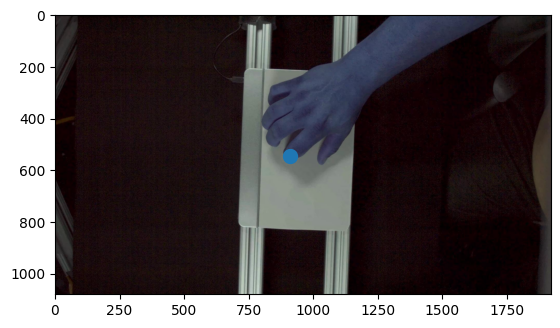

In [143]:
x = []
y = []

for landmark in detection_result.hand_landmarks[0]:
    x.append(landmark.x * 1920)
    y.append(landmark.y * 1080)
image = cv2.imread(path)
plt.scatter(x[8], y[8], linewidths=5)
plt.imshow(image)

In [97]:
coords = np.array((x[8], y[8])).astype(int)

In [98]:
x_min, y_min = coords - 20 - 80
x_max, y_max = coords + 20 + 80
x_min, y_min = max(x_min,0), max(y_min,0)
x_max, y_max = min(x_max, 1920) , min(y_max, 1080)

In [111]:
model = torchvision.models.vit_b_32(weights=torchvision.models.ViT_B_32_Weights.DEFAULT)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.heads = nn.Sequential(nn.Linear(768, 256), 
                            nn.GELU(),
                            nn.BatchNorm1d(256),
                            nn.Linear(256, 1))
model = model.to(device)

In [112]:
model.load_state_dict(torch.load("touch_vit_models/model_weights2.1_complete.pth"))

/tmp/ipykernel_1402592/2727681702.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("touch_vit_models/model_weights2.1_complete.pth"))


<All keys matched successfully>

In [113]:
transforms = torchvision.models.ViT_B_32_Weights.IMAGENET1K_V1.transforms()

In [124]:
input = transforms(torch.tensor(image[y_min:y_max, x_min:x_max].transpose(2, 0, 1)))
input = input[np.newaxis].to(device)

In [125]:
input.shape

torch.Size([1, 3, 224, 224])

In [128]:
model.eval()
output = model(input)
pred = torch.round(torch.sigmoid(output))

In [129]:
pred

tensor([[0.]], device='cuda:1', grad_fn=<RoundBackward0>)

In [141]:
def locate_index(img):
    detection_result = detector.detect(img)
    x = detection_result.hand_landmarks[0][8].x * 1920
    y = detection_result.hand_landmarks[0][8].y * 1080
    coords = np.array((x, y)).astype(int)
    x_min, y_min = coords - 20 - 80
    x_max, y_max = coords + 20 + 80
    x_min, y_min = max(x_min,0), max(y_min,0)
    x_max, y_max = min(x_max, 1920) , min(y_max, 1080)

    return x_min, x_max, y_min, y_max

In [ ]:
def process_img(img):
    

In [144]:
image = mp.Image.create_from_file(path)
x_min, x_max, y_min, y_max = locate_index(image)

/home/brianchen/.local/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [153]:
image_arr = cv2.imread(path)
input = transforms(torch.tensor(image_arr[y_min:y_max, x_min:x_max].transpose(2, 0, 1)))[np.newaxis]
input = input.to(device)

In [156]:
model.eval()
pred = torch.round(torch.sigmoid(model(input)))

In [158]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'))
cap.set(cv2.CAP_PROP_FPS, 30)

[ WARN:0@9657.915] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@9657.915] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range


False